In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# 1. Creating TikTak player

In [13]:
class PacardoPlayer:
    """
        defines simple AI player
        @constructors:
            __init__(self, player_name, symbol = 1, exp_rate=0.3) - creates PacardoPlayer object
        @methods:
            - getHash(board) - returns string representation of board passed
            - availablePositions(current_board) - returns empty cells on board passed
            - get_action(current_board) - returns (i,j) formatted player turn
            - is_done(reward) - give player a revard
            - savePolicy() - saves policy for player, after end of the game
    """
    BOARD_ROWS=3
    BOARD_COLS=3
    def __init__(self, player_name, symbol = 1, exp_rate=0.3):
        self.name = player_name
        self.symbol = symbol
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

    def getHash(self, board):
        boardHash = str(board.reshape(self.BOARD_COLS * self.BOARD_ROWS))
        return boardHash
    
    def availablePositions(self, board):
        positions = []
        for i in range(self.BOARD_ROWS):
            for j in range(self.BOARD_COLS):
                if board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions
    
    def get_action(self, current_board):
        positions = self.availablePositions(current_board)
        if np.random.uniform(0, 1) <= self.exp_rate:
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = self.symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None\
                        else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        current_board[action] = self.symbol            
        self.addState(self.getHash(current_board))            
        return action            
        return action
    
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def is_done(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]
        self.reset()

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

# 2. Creating mediator for player

In [14]:
class PlayerMediator:
    '''
        defines mediator for PacardoPlayer class
        should be used to adapt player to gaming process
        
        @constructors:
            __init__(self, isZero, name[OPTIONAL]) - creates player mediator object
        
        @methods:
            - _transform_board(board) - encodes/decodes board for player
            - get_action(self, state) - returns player action
            - is_done(self, state, reward) - rewards player at the end of the game
            - save_state() - saves policy for player
    '''
    def __init__(self, isZero = False, name = "pacardo_machine"):
        self.player = PacardoPlayer(
            player_name = name,
            symbol = -1 if (isZero) else 1
        )
            
    def _transform_board(self, board):
        board = np.where(board==-1, 2, board)
        board = np.where(board==0, -1, board)
        board = np.where(board==2, 0, board)
        return board
    
    def get_action(self, state):
        return self.player.get_action(self._transform_board(state))
    
    def is_done(self, state, reward):
        self.player.is_done(reward)
    
    def save_weight(self):
        self.player.savePolicy()

# 3. Creating gaming process

In [15]:
def check_win(a,lable):
    for i in range(3):
        if np.all(a[i,:] == int(lable)):
            return True
        elif np.all(a[:,i] == int(lable)):
            return True
    if np.all(np.fliplr(a).diagonal() == int(lable)):
        return True
    if np.all(a.diagonal() == int(lable)):
        return True
    return False

In [16]:
def two_came_in_one_came_out(agent_zeros, agent_ones, print_state = False):
    state = (np.zeros((3,3))-1).astype('int')
    while -1 in state:
        #ход креста
        state[agent_ones.get_action(state)] = 1
        if print_state:
            print(state)
            print()
        if check_win(state, 1):
            agent_ones.is_done(state, True)
            agent_zeros.is_done(state, False)
            return 1
        if not(-1 in state):
            break
        state[agent_zeros.get_action(state)] = 0
        if print_state:
            print(state)
            print()
        if check_win(state, 0):
            agent_ones.is_done(state, False)
            agent_zeros.is_done(state, True)
            return 0
    agent_ones.is_done(state, False)
    agent_zeros.is_done(state, False)
    return -1


def fit(agent_zeros, agent_ones, epochs, step_per_epoch, save_config = False, plot_win = False):
    history = {
        'epoch':[],
        'zeros win':[],
        'ones win':[],
        'draw':[]
    }
    for epoch in tqdm(np.arange(epochs)):
        z_win = 0
        o_win = 0
        draw = 0
        for step in np.arange(step_per_epoch):
            play_result = two_came_in_one_came_out(agent_zeros, agent_ones)
            if play_result == 0:
                z_win += 1
            elif play_result == 1:
                o_win += 1
            else:
                draw += 1
        history['epoch'].append(epoch)
        history['zeros win'].append(z_win)
        history['ones win'].append(o_win)
        history['draw'].append(draw)
    history = pd.DataFrame(history)
    if plot_win:
        plt.figure(figsize=(10, 8))
        plt.plot(history['epoch'], (history['zeros win']/step_per_epoch)*100, 'b-', label = '% побед нуля в эпохе')
        plt.plot(history['epoch'], (history['ones win']/step_per_epoch)*100, 'r-', label = '% побед креста в эпохе')
        plt.plot(history['epoch'], (history['draw']/step_per_epoch)*100, 'k--', label = '% ничей в эпохе')
        plt.xlim([0,epochs])
        plt.ylim([0,101])
        plt.grid()
        plt.legend()
        plt.show()
    if save_config:
        agent_ones.save_weight()
        agent_zeros.save_weight()

# 4. Player training

100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


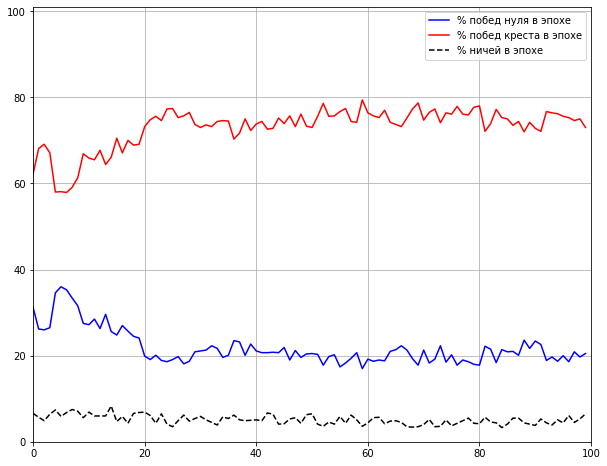

In [17]:
one_player = PlayerMediator(isZero=False, name="Pacardo_Machine_1")
zero_player = PlayerMediator(isZero=True, name="Pacardo_Machine_2")
fit(
    zero_player,
    one_player,
    epochs = 100,
    step_per_epoch = 1000,
    save_config = True,
    plot_win = True
)

# 5. Competitions

### 5.1 kirill code

In [24]:
class Game:
    
    def __init__(self, field=None):
        self.field = None
        
        if field:
            self.field = field
        else:
            self.start()
    
    def start(self):
        self.field = [' ']*9

    def printField(self):
        row = ''
        for i in range(len(self.field)):
            cell = self.field[i]
            row+='['
            if cell != ' ':
                row+=cell
            else:
                row+=str(i+1)
            row+=']'
            if (i % 3 == 2): 
                print(row)
                row = ''
    
    def set(self, position, side):
        pos = int(position)-1
        self.field[pos] = side

    def getFree(self):
        free = []
        for i in range(len(self.field)):
            cell = self.field[i]
            if (cell == ' '):
                free.append( (i+1) )
        return free
    
    def isDraw(self):
        free = self.getFree();
        return len(free)==0;
    
    def isWin(self, side):
        for i in range(3):
            isW = True 
            for j in range(3):
                if self.field[i*3+j]!=side:
                    isW = False
                    break
            if isW:
                return isW
            
        for i in range(3):
            isW = True 
            for j in range(3):
                if self.field[j*3+i]!=side:
                    isW = False
                    break
            if isW:
                return isW
            
        isW = True;
        for i in range(3):
            if self.field[i*3+i]!=side:
                isW = False
                break
        if isW:
            return isW
        
        isWi = True;
        for i in range(3):
            if self.field[(i*3+2-i)]!=side:
                isW = False
                break
        if isW:
            return isW

        return False
    
    def getState(self, side):
        if side == 'x':
            return self.field

        newField = ''
        for i in range(len(self.field)):
            if self.field[i]=='x':
                newField += 'o'
            elif self.field[i]=='o':
                newField += 'x'
            else:
                newField += self.field[i] 

        return newField


In [25]:
import os
import json

class AI:
    def __init__(self):
        self.table = {}
        if os.path.isfile('./rewards.json'):
            with open('rewards.json') as json_file:
                self.table = json.load(json_file)
                print("loaded AI from rewards.json")

    def getReward(self, state):
        game = Game(state)
        
        #если победитель - мы, то оценка состояния игры "1"
        if game.isWin('x'):
            return 1

        #если победиль - соперник, то оценка состояния игры "0"
        if game.isWin('o'):
            return 0

        #смотрим ценность по таблице
        strstate = ''.join(state)
        if strstate in self.table.keys():
            return self.table[strstate]

        #если в таблице нет, то считаем начальной ценностью "0.5"
        return 0.5

    def correct(self, state, newReward):
        oldReward = self.getReward(state)
        strstate = ''.join(state)
        self.table[strstate] = oldReward + 0.1 * (newReward - oldReward)

    def save(self):
        with open('rewards.json', 'w') as outfile:
            json.dump(self.table, outfile)

In [26]:
import random 
import copy

class AIPlayer:
    
    def __init__(self, side, ai, isGreedy=True):
        self.side = side
        self.ai = ai
        self.oldState = None
        self.isGreedy = isGreedy

    def getSide(self):
        return self.side

    def makeStep(self, game):
        #получаем список доступных ходов
        free = game.getFree()
        
        #решаем, является ли текущий ход 
        #зондирующим (случайным) или жадным (максимально выгодным)
        
        if not self.isGreedy:
            #случайный ход
            print('Random step')
            step = random.choice(free)
            game.set(step, self.side)
            self.oldState = game.getState(self.side)
            return step

        #жадный ход
        rewards = {}
        for step in free:
            # для каждого доступного хода оцениваем состояние игры после него
            newGame = copy.deepcopy(game)
            newGame.set(step, self.side)
            rewards[step] = self.ai.getReward(newGame.getState(self.side))

        #выясняем, какое вознаграждение оказалось максимальным
        maxReward = 0
        for reward in rewards.values():
            if reward > maxReward:
                maxReward = reward

        #находим все шаги с максимальным вознаграждением
        steps = []
        
        for step in rewards:
            reward = rewards[step]
            if (maxReward > (reward - 0.01)) and (maxReward < (reward + 0.01)):
                steps.append(step)

        #корректируем оценку прошлого состояния
        #с учетом ценности нового состояния
        if (self.oldState):
            self.ai.correct(self.oldState, maxReward)

        #выбираем ход из ходов с максимальный вознаграждением
        step = random.choice(steps)
        game.set(step, self.side)

        #сохраняем текущее состояние для того, 
        #чтобы откорректировать её ценность на следующем ходе
        self.oldState = game.getState(self.side)
        return step

    def loose(self):
        #корректируем ценность предыдущего состояния при проигрыше
        if self.oldState:
            self.ai.correct(self.oldState, 0)

    def win(self):
        #корректируем ценность предыдущего состояния при выигрыше
        if self.oldState:
            self.ai.correct(self.oldState, 1)
    
    def draw(self):
        #корректируем ценность предыдущего состояния при ничьей
        if self.oldState:
            self.ai.correct(self.oldState, 0.5)

In [27]:
class UserPlayer:

    def __init__(self, side):
        self.side = side

    def getSide(self):
        return self.side

    def makeStep(self, game):
        game.printField()
        
        free = game.getFree()

        inp = None
        while (True):
            inp = input()
            if int(inp) in free:
                break
        
        game.set(inp, self.side)

    def loose(self):
        print('you loose')

    def win(self):
        print('you win')

    def draw(self):
        print('draw')

In [28]:
def state_to_gmstate(state):
    """
    Переводим состояние игры из формата массива в формат строки,
    который используется игрой
    """
    gmstate = []
    for row in state:
        for ch in row:
            if ch == -1:
                gmstate.append(' ')
            elif ch == 1:
                gmstate.append('x')
            else:
                gmstate.append('o')
    return gmstate
def gmstep_to_step(step):
    """
    Переводим обозначение хода из принятого в игре 
    в формат который ожидается на выходе агента
    """
    steps = {
        1:(1,1),
        2:(1,2),
        3:(1,3),
        4:(2,1),
        5:(2,2),
        6:(2,3),
        7:(3,1),
        8:(3,2),
        9:(3,3),
    }
    return (steps[step][0]-1,steps[step][1]-1)

In [29]:
class AgentTicTacGreedy:
    
    def __init__(self, is_zero):
        #is_zero == True если нолик
        self.player = None
        ai = AI()
        if is_zero:
            self.player = AIPlayer('o', ai, True)
        else:
            self.player = AIPlayer('x', ai, True)

    def get_action(self, state):
        # пример state = [[1,0,1],[0,1,0],[0,1,0]] 1 - это крестик, 0 - это нолик, -1 - пусто
        gmstate = state_to_gmstate(state)
        game = Game(field=gmstate)
        move = self.player.makeStep(game)
        return gmstep_to_step(move) # возвращаем координаты хода

    def is_done(self, state, reward):
        # reward - вознаграждение 1 если выиграли , вызывается когда игра закончена
        gmstate = state_to_gmstate(state)
        game = Game(field=gmstate)
        return game.isWin(self.player.getSide())

### 5.2 Competitions 🏆

100%|██████████| 20/20 [00:01<00:00, 11.73it/s]


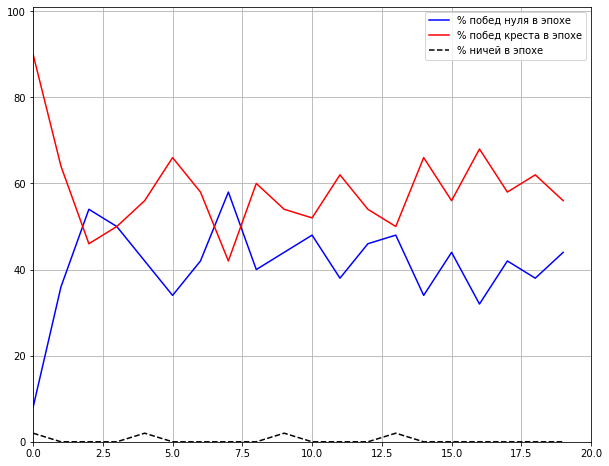

In [30]:
zeros = PlayerMediator(True)
ones = AgentTicTacGreedy(False)
fit(zeros, ones, epochs = 20, step_per_epoch = 50, save_config = False, plot_win = True)

### вывод: видно из графика, наша модель, почти во всех играх побеждает модель кирилла.

# 6. Genetics algoritm ([referensed here](https://www.iitk.ac.in/kangal/papers/k2007002.pdf))

In [5]:
import enum
import random
import math

class GridCell(enum.Enum):
    E = 0
    X = 1
    O = 2


class Outcome(enum.Enum):
    Xwin = 765
    Owin = 766
    Tie = 767


class Rank(enum.Enum):
    Best = 0
    Worst = 1


class Pair:
    def __init__(self, result, bestStrategy):
        self.bestStrategy = bestStrategy
        self.result = result


class Agent:

    def __init__(self):
        self.InputFile = "base_matrix"
        self.BoardSize = 9
        self.IndividualSize = 765
        self.PopulationSize = 50
        self.CrossoverChance = 0.95
        self.MutationChance = 0.03
        self.GenerationsCount = 100
        self.baseStateMatrix = []
        for z in range(0, 3):
            for j in range(0, 3):
                for k in range(0, 3):
                    for l in range(0, 3):
                        for m in range(0, 3):
                            for n in range(0, 3):
                                for p in range(0, 3):
                                    for q in range(0, 3):
                                        for r in range(0, 3):
                                            level = 0
                                            temp = [GridCell(z), GridCell(j), GridCell(k), GridCell(l), GridCell(m), GridCell(n), GridCell(p), GridCell(q), GridCell(r)]
                                            for idx in range(len(temp)):
                                                if temp[idx] != GridCell.E:
                                                    level += 1
                                            if self.stateIsAcceptable(temp):
                                                temp = self.getBaseCaseMatrix(temp)
                                                temp.append(level)
                                                flag = False
                                                for x in self.baseStateMatrix:
                                                    flag = True
                                                    for s in range(len(x)):
                                                        if x[s] != temp[s]:
                                                            flag = False
                                                            break
                                                    if flag:
                                                        break

                                                if not flag:
                                                    self.baseStateMatrix.append(temp)



        self.sortEnum(self.baseStateMatrix)
        self.Population = []
        for i in range(self.PopulationSize):
            Individuals = []
            for s in range(self.IndividualSize):
                cureState = self.baseStateMatrix[s]
                Individuals.append(self.nextMove(cureState))

            self.Population.append(Individuals)

    def sortEnum(self, list):
        for i in range(len(list)):
            for j in range(i + 1, len(list)):
                if list[j] == GridCell.O and list[i] != GridCell.O:
                    temp = list[j]
                    list[j] = list[i]
                    list[i] = temp

                elif list[j] == GridCell.X and list[i] == GridCell.E:
                    temp = list[j]
                    list[j] = list[i]
                    list[i] = temp


    def lexicographicalCompare(self, board1, board2):
        for i in range(9):
            if board1[i] == GridCell.O and board2[i] != GridCell.O:
                return True

            elif board1[i] == GridCell.X and board2[i] == GridCell.E:
                return True

            elif board2[i] == GridCell.O and board1[i] != GridCell.O:
                return False

            elif board2[i] == GridCell.X and board1[i] == GridCell.E:
                return False

        return True

    def hasPriority(self, board1, board2):
        sumX1 = 0
        sumO1 = 0
        sumX2 = 0
        sumO2 = 0
        mulX1 = 1
        mulO1 = 1
        mulX2 = 1
        mulO2 = 1
        for i in range(9):
            sumX1 += i * (board1[i] == GridCell.X)
            sumX2 += i * (board2[i] == GridCell.X)
            sumO1 += i * (board1[i] == GridCell.O)
            sumO2 += i * (board2[i] == GridCell.O)
            mulX1 *= i * (board1[i] == GridCell.X)
            mulX2 *= i * (board2[i] == GridCell.X)
            mulO1 *= i * (board1[i] == GridCell.O)
            mulO2 *= i * (board2[i] == GridCell.O)

        if sumX1 == sumX2:
            if sumO1 == sumO2:
                if mulX1 == mulX2:
                    if mulO1 == mulO2:
                        return self.lexicographicalCompare(board1, board2)
                    else:
                        return mulO1 < mulO2
                else:
                    return mulX1 < mulX2
            else:
                return sumO1 < sumO2
        else:
            return sumX1 < sumX2

    def isWinner(self, board, player):
        if board[0] == player and board[0] == board [1] and board[1] == board [2]:
            return True
        elif board[3] == player and board[3] == board [4] and board[4] == board [5]:
            return True
        elif board[6] == player and board[6] == board [7] and board[7] == board [8]:
            return True
        elif board[0] == player and board[0] == board [4] and board[4] == board [8]:
            return True
        elif board[2] == player and board[2] == board [4] and board[4] == board [6]:
            return True
        elif board[0] == player and board[0] == board [3] and board[3] == board [6]:
            return True
        elif board[1] == player and board[1] == board [4] and board[4] == board [7]:
            return True
        elif board[2] == player and board[2] == board [5] and board[5] == board [8]:
            return True
        else:
            return False

    def stateIsAcceptable(self, board):
        xCount = 0
        oCount = 0
        for i in range(len(board)):
            if board[i] == GridCell.X:
                xCount += 1
            elif board[i] == GridCell.O:
                oCount += 1
        if xCount == oCount or xCount == oCount + 1:
            if not self.isWinner(board, GridCell.X) and not self.isWinner(board, GridCell.O):
                return True
            elif not self.isWinner(board, GridCell.X) and self.isWinner(board, GridCell.O) and oCount == xCount:
                return True
            elif self.isWinner(board, GridCell.X) and not self.isWinner(board, GridCell.O) and xCount == oCount + 1:
                return True
            else:
                return False
        else:
            return False

    def getBaseCaseMatrix(self, state):

        states = [
            [state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8]],
            [state[6], state[3], state[0], state[7], state[4], state[1], state[8], state[5], state[2]],
            [state[8], state[7], state[6], state[5], state[4], state[3], state[2], state[1], state[0]],
            [state[2], state[5], state[8], state[1], state[4], state[7], state[0], state[3], state[6]],
            [state[6], state[7], state[8], state[3], state[4], state[5], state[0], state[1], state[2]],
            [state[8], state[5], state[2], state[7], state[4], state[1], state[6], state[3], state[0]],
            [state[2], state[1], state[0], state[5], state[4], state[3], state[8], state[7], state[6]],
            [state[0], state[3], state[6], state[1], state[4], state[7], state[2], state[5], state[8]]
        ]
        baseState = 0
        for i in range (len(states)):
            if self.hasPriority(states[i], states[baseState]):
                baseState = i

        return states[baseState]

    def play(self, player1, player2):
        step = 0
        state = []

        while True:

            if player1[step] != Outcome.Xwin and player1[step] != Outcome.Owin and player1[step] != Outcome.Tie:
                if player1[step] < self.IndividualSize:
                    state = self.baseStateMatrix[player1[step]]
                    step = player1[step]

            else:
                return Outcome(player1[step])

            if player2[step] != Outcome.Xwin and player2[step] != Outcome.Owin and player2[step] != Outcome.Tie:
                if player2[step] < self.IndividualSize:
                    state = self.baseStateMatrix[player2[step]]
                    step = player2[step]

            else:
                return Outcome(player2[step])

    def nextMove(self, cureState):
        diff = 0
        empty = 0
        for b in range(self.BoardSize):
            if cureState[b] == GridCell.X:
                diff += 1

            elif cureState[b] == GridCell.O:
                diff -= 1

            elif cureState[b] == GridCell.E:
                empty += 1

        if self.isWinner(cureState, GridCell.X):
            return Outcome.Xwin

        elif self.isWinner(cureState, GridCell.O):
            return Outcome.Owin

        elif empty == 0:
            return Outcome.Tie

        else:
            nextLevel = cureState[9] + 1
            possibleStates = set()
            for i in range(self.BoardSize):
                tempBoard = cureState[0:9]
                if tempBoard[i] == GridCell.E:
                    tempBoard[i] = GridCell(diff + 1)
                    tempBoard[0:9] = self.getBaseCaseMatrix(tempBoard[0:9])
                    tempBoard.append(nextLevel)
                    index = self.baseStateMatrix.index(tempBoard)
                    if index != self.IndividualSize:
                        possibleStates.add(index)

            step = random.randint(0, len(possibleStates) - 1)
            return list(possibleStates)[step]

    def fitness(self, candidate):
        loseCount = 0
        for i in range(len(self.Population)):
            player = self.Population[i]
            result = self.play(player, candidate)
            if result == Outcome.Owin:
                loseCount += 1

            result = self.play(candidate, player)
            if result == Outcome.Xwin:
                loseCount += 1
        f = loseCount / (2 * len(self.Population))
        return f

    def choose(self, rank):
        if rank == Rank.Best:
            result = self.PopulationSize * 2.0
        else:
            result = 0.0
        bestStrategy = 0

        for i in range(len(self.Population)):
            f = self.fitness(self.Population[i])

            if rank == Rank.Best:
                if f < result:
                    result = f
                    bestStrategy = i

            else:
                if f > result:
                    result = f
                    bestStrategy = i

        return Pair(result, bestStrategy)

    def selection(self):
        candidates = []
        for i in  range(int(len(self.Population)/2)):
            index = random.randint(0, len(self.Population) - 1)
            c = Pair(self.fitness(self.Population[index]), self.Population[index])
            candidates.append(c)
        candidates.sort(key=lambda x: x.result)
        #return Pair(candidates[0].bestStrategy, candidates[1].bestStrategy)
        returnValue = []
        for i in range(5):
            returnValue.append(candidates[i].bestStrategy)
        return returnValue

    def crossover(self, individuals):
        for i in range(len(individuals)):
            r = random.uniform(0, 1)
            if r < self.CrossoverChance:
                p1 = random.randint(0, len(individuals) - 1)
                p2 = random.randint(0, len(individuals) - 1)
                rand1 = random.randint(0, len(individuals[p1]))
                rand2 = random.randint(0, len(individuals[p2]))
                cutpoint1 = min(rand1, rand2)
                cutpoint2 = max(rand1, rand2)
                for i in range(cutpoint1, cutpoint2):
                    temp = individuals[p1][i]
                    individuals[p1][i] = individuals[p2][i]
                    individuals[p2][i] = temp

        return individuals

    def mutation(self, individuals):
        r = random.uniform(0, 1)
        if r < self.MutationChance:
            index = random.randint(0, len(individuals))
            state = self.baseStateMatrix[index]
            nxtMove = self.nextMove(state)
            individuals[index] = nxtMove

        return individuals


In [6]:
agent = Agent()
for i in range(agent.GenerationsCount):
    p = agent.selection()
    c = agent.crossover(p)
    for j in range(len(c)):
        agent.Population[agent.choose(Rank.Worst).bestStrategy] = c[j]
    for k in range(len(p)):
        agent.Population[agent.choose(Rank.Worst).bestStrategy] = p[k]
    for l in range(len(agent.Population)):
        agent.mutation(agent.Population[l])

result = agent.choose(Rank.Best)
print("The Percentage of Lost Games is = ", result.result * 100)
print("The Strategy is :")
bestAnswer = agent.Population[result.bestStrategy]
for i in range(len(bestAnswer)):
    print(i, " --> ", bestAnswer[i])

print()

The Percentage of Lost Games is =  0.0
The Strategy is :
0  -->  2
1  -->  133
2  -->  76
3  -->  70
4  -->  131
5  -->  134
6  -->  324
7  -->  146
8  -->  57
9  -->  181
10  -->  84
11  -->  250
12  -->  62
13  -->  138
14  -->  139
15  -->  18
16  -->  65
17  -->  38
18  -->  40
19  -->  20
20  -->  67
21  -->  409
22  -->  44
23  -->  46
24  -->  148
25  -->  28
26  -->  27
27  -->  99
28  -->  29
29  -->  124
30  -->  31
31  -->  208
32  -->  152
33  -->  125
34  -->  206
35  -->  298
36  -->  92
37  -->  38
38  -->  102
39  -->  204
40  -->  98
41  -->  46
42  -->  43
43  -->  284
44  -->  423
45  -->  46
46  -->  422
47  -->  49
48  -->  161
49  -->  421
50  -->  53
51  -->  104
52  -->  64
53  -->  67
54  -->  171
55  -->  63
56  -->  57
57  -->  61
58  -->  63
59  -->  219
60  -->  166
61  -->  120
62  -->  238
63  -->  394
64  -->  109
65  -->  218
66  -->  438
67  -->  116
68  -->  117
69  -->  Outcome.Xwin
70  -->  344
71  -->  72
72  -->  73
73  -->  523
74  -->  90
75  --

### Вывод: генетический алгоритм хорошо себя показал. Лучший агент смог не проиграть ни одну игру. Следовательно, цель обучения достигнута